In [1]:
library(dplyr)
library(caret)
library(ggplot2)
library(viridis)
library(tidyverse)
library(h2o)
library(gt)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice

Loading required package: viridisLite

Warning message:
"package 'tidyverse' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::lift()   masks caret::lift()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'h2o' was built under R version 4.4.3"

-------------------------------

In [2]:
h2o.init()


H2O is not running yet, starting it now...


Warning message in .h2o.startJar(ip = ip, port = port, name = name, nthreads = nthreads, :
"You have a 32-bit version of Java. H2O works best with 64-bit Java.
Please download the latest Java SE JDK from the following URL:
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements"



Note:  In case of errors look at the following log files:
    C:\Users\willk\AppData\Local\Temp\RtmpM5B3Qf\fileb28496fbd9/h2o_willk_started_from_r.out
    C:\Users\willk\AppData\Local\Temp\RtmpM5B3Qf\fileb2838c668af/h2o_willk_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         7 seconds 68 milliseconds 
    H2O cluster timezone:       America/New_York 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.44.0.3 
    H2O cluster version age:    1 year, 11 months and 22 days 
    H2O cluster name:           H2O_started_from_R_willk_iom104 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.97 GB 
    H2O cluster total cores:    16 
    H2O cluster allowed cores:  16 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 

Warning message in h2o.clusterInfo():
"
Your H2O cluster version is (1 year, 11 months and 22 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html"


In [4]:
df <- read.csv("full_clean_data.csv")
df <- df %>% 
  group_by(game_id, play_id) %>% 
  mutate(final_frame = ifelse(max(frame_id) == frame_id, 1, 0))

In [5]:
df_filtered <- df %>%
  drop_na(dist_to_ball_land, speed, accel, direction, accel_direction, optimal_angle, angle_diff)

df_filtered <- df_filtered %>%
  group_by(game_id, play_id, nfl_id) %>%
  mutate(reached_ball = ifelse(dist_to_ball_land < 1.5, 1, 0)) %>% 
  mutate(reached_ball = ifelse(any(final_frame == 1 & reached_ball == 1), 1, 0)) %>%
  ungroup()

In [23]:
model <- h2o.loadModel(file.path("h2o_models", "model_with_id_dl"))

In [ ]:
model <- h2o.deeplearning(
  x = features,
  y = target,
  training_frame = train_h2o,
  hidden = c(64, 32),
  epochs = 30,
  activation = "Rectifier",
  categorical_encoding = "OneHotInternal",
  stopping_metric = "AUC",
  seed = 123
)

model <- h2o.gbm(
  x = features,
  y = target,
  training_frame = train_h2o,
  seed = 123
)

  |===============                                                       |  21%

: 

In [26]:
df_model <- df_filtered %>%
  mutate(
    nfl_id = as.factor(nfl_id),
    reached_ball = as.factor(reached_ball)
  ) %>%
  select(dist_to_ball_land, speed, accel, angle_diff, time_left_s, nfl_id, reached_ball)


set.seed(123)
train_idx <- sample(1:nrow(df_model), 0.8 * nrow(df_model))
train <- df_model[train_idx, ]
test  <- df_model[-train_idx, ]


train_h2o <- as.h2o(train)
test_h2o  <- as.h2o(test)


features <- c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s", "nfl_id")
target   <- "reached_ball"




perf <- h2o.performance(model, newdata = test_h2o)
h2o.auc(perf)
h2o.confusionMatrix(perf)


pred <- h2o.predict(model, test_h2o)
pred_probs <- as.vector(pred$p1)
pred_class <- as.vector(pred$predict)




  |======================================================================| 100%
  |======================================================================| 100%


[1] 0.9959188

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,85167,1727,0.01987479,=1727/86894
1,1379,24315,0.05367012,=1379/25694
Totals,86546,26042,0.02758731,=3106/112588


  |======================================================================| 100%


In [28]:
h2o.saveModel(model, path = "h2o_models", force = TRUE, filename = "model_with_id_gbm")

[1] "D:\\github\\BigDataBowl2025\\h2o_models\\model_with_id_gbm"

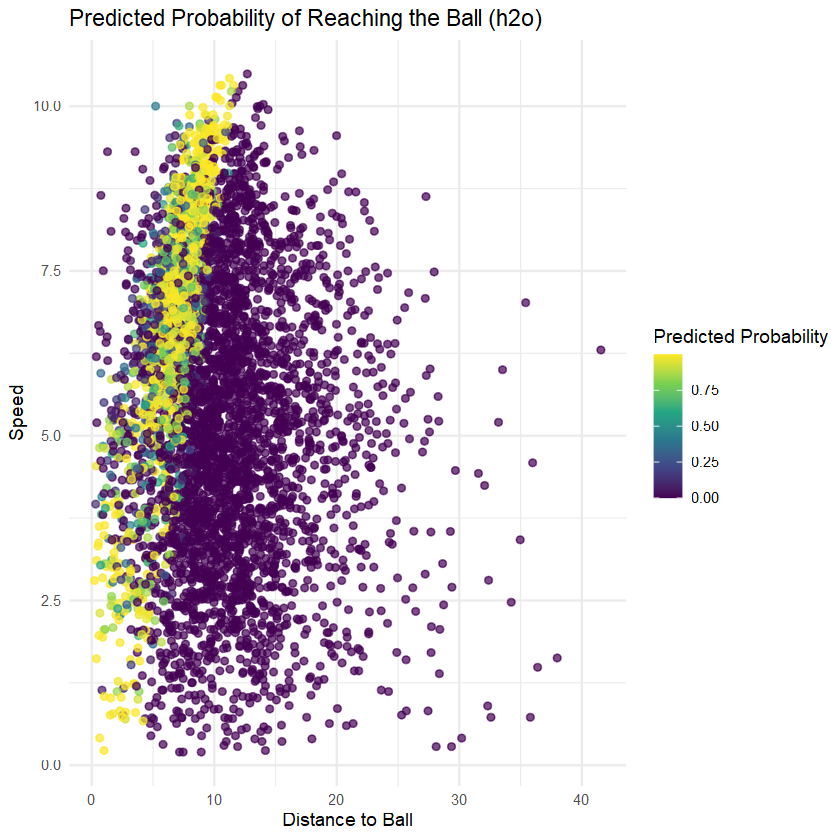

In [27]:
plot_df <- as.data.frame(test_h2o) %>%
  mutate(pred_prob = pred_probs)

ggplot(plot_df |> filter(time_left_s == 1), aes(x = dist_to_ball_land, y = speed, color = pred_prob)) +
  geom_point(alpha = 0.7) +
  scale_color_viridis_c() +
  labs(
    title = "Predicted Probability of Reaching the Ball (h2o)",
    x = "Distance to Ball",
    y = "Speed",
    color = "Predicted Probability"
  ) +
  theme_minimal()

In [ ]:
model_no_id <- h2o.deeplearning(
  x = c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s"),
  y = target,
  training_frame = train_h2o,
  hidden = c(64, 32),
  epochs = 30,
  activation = "Rectifier",
  stopping_metric = "AUC",
  seed = 123
)

  |======================================================================| 100%


In [8]:
model_no_id <- h2o.gbm(
  x = c("dist_to_ball_land", "speed", "accel", "angle_diff", "time_left_s"),
  y = target,
  training_frame = train_h2o,
  seed = 123
)

  |======================================================================| 100%


In [9]:
h2o.saveModel(model_no_id, path = "h2o_models", force = TRUE, filename = "model_no_id_gbm")

[1] "C:\\Users\\willk\\Documents\\GitHub\\BigDataBowl2025\\h2o_models\\model_no_id_gbm"

In [24]:
model_no_id <- h2o.loadModel(file.path("h2o_models", "model_no_id"))

In [28]:
perf2 <- h2o.performance(model_no_id, newdata = test_h2o)
h2o.auc(perf2)
h2o.confusionMatrix(perf2)


pred2 <- h2o.predict(model_no_id, test_h2o)
pred_probs2 <- as.vector(pred2$p1)
pred_class2 <- as.vector(pred2$predict)

plot_df <- plot_df %>% 
  mutate(prob2 = pred_probs2) %>% 
  mutate(effect = pred_prob - prob2)
  

[1] 0.99166

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,83584,3310,0.03809239,=3310/86894
1,1682,24012,0.06546275,=1682/25694
Totals,85266,27322,0.04433865,=4992/112588


  |======================================================================| 100%


In [13]:
library(nflreadr)
players <- load_players()

In [29]:
plot_df <- plot_df %>% 
  left_join(players %>% 
              select(nfl_id, display_name, pff_position), by = c("nfl_id"))


In [30]:
plot_df %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  filter(n > 50) %>% 
  arrange(desc(avg)) %>%
  head()

nfl_id,name,n,avg,total,pos
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
44978,Jamal Agnew,55,0.13881,7.63444,WR
54694,Bo Melton,64,0.12120,7.75705,WR
47879,Dawson Knox,56,0.11044,6.18453,TE
54483,Treylon Burks,52,0.10557,5.48953,WR
44881,Cooper Kupp,211,0.10199,21.51889,WR
55943,Tucker Kraft,61,0.08926,5.44483,TE


In [31]:
varimp <- h2o.varimp(model)
varimp

variable,relative_importance,scaled_importance,percentage
<chr>,<dbl>,<dbl>,<dbl>
dist_to_ball_land,1.0000000,1.0000000,0.010496192
time_left_s,0.6799426,0.6799426,0.007136808
angle_diff,0.5078845,0.5078845,0.005330853
speed,0.3753309,0.3753309,0.003939545
nfl_id.45004,0.2557024,0.2557024,0.002683902
nfl_id.52417,0.2236388,0.2236388,0.002347356
nfl_id.55133,0.2173330,0.2173330,0.002281169
nfl_id.55965,0.1951900,0.1951900,0.002048752
nfl_id.55904,0.1928116,0.1928116,0.002023788


In [32]:
perf3 <- h2o.performance(model, newdata = as.h2o(df_filtered))
h2o.auc(perf3)
h2o.confusionMatrix(perf3)


pred3 <- h2o.predict(model, as.h2o(df_filtered))
pred_probs3 <- as.vector(pred3$p1)
pred_class3 <- as.vector(pred3$predict)

  |======================================================================| 100%


[1] 0.9971522

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,426004,7482,0.01726007,=7482/433486
1,5780,123670,0.04465044,=5780/129450
Totals,431784,131152,0.02355863,=13262/562936


  |======================================================================| 100%
  |======================================================================| 100%


In [33]:
perf4 <- h2o.performance(model_no_id, newdata = as.h2o(df_filtered))
h2o.auc(perf4)
h2o.confusionMatrix(perf4)


pred4 <- h2o.predict(model_no_id, as.h2o(df_filtered))
pred_probs4 <- as.vector(pred4$p1)
pred_class4 <- as.vector(pred4$predict)


  |======================================================================| 100%


[1] 0.9915221

,0,1,Error,Rate
,<dbl>,<dbl>,<dbl>,<chr>
0,417173,16313,0.03763213,=16313/433486
1,8635,120815,0.06670529,=8635/129450
Totals,425808,137128,0.04431765,=24948/562936


  |======================================================================| 100%
  |======================================================================| 100%


In [34]:
data <- df_filtered %>% 
  mutate(pred1 = pred_probs3, pred2 = pred_probs4, effect = pred1 - pred2) %>% 
  left_join(players %>% mutate(nfl_id = as.numeric(nfl_id)) %>% select(nfl_id, display_name, pff_position), by = c("nfl_id"))


In [35]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "CB") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
39984,Darius Slay,1742,0.04440,77.35276,CB
42441,Steven Nelson,1742,0.03690,64.27635,CB
56353,Starling Thomas V,701,0.08474,59.40584,CB
46456,Darious Williams,1917,0.02762,52.95462,CB
43700,Jonathan Jones,1321,0.03690,48.73856,CB
52547,Amik Robertson,1239,0.03425,42.44090,CB
46190,Taron Johnson,1750,0.02394,41.90126,CB
47822,Sean Murphy-Bunting,1341,0.03052,40.92880,CB
43986,Antonio Hamilton,877,0.04643,40.71477,CB


In [36]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "WR") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
53541,Amon-Ra St. Brown,1496,0.07037,105.27935,WR
52433,Brandon Aiyuk,1298,0.07999,103.82839,WR
44881,Cooper Kupp,1052,0.08240,86.68195,WR
53434,Ja'Marr Chase,1383,0.06113,84.54074,WR
43454,Tyreek Hill,1792,0.04209,75.42343,WR
52430,Justin Jefferson,1205,0.05346,64.42357,WR
52441,Tee Higgins,885,0.06841,60.54632,WR
53435,Jaylen Waddle,1031,0.05548,57.19897,WR
53486,Tutu Atwell,766,0.07461,57.14983,WR


In [38]:
data %>% 
  group_by(nfl_id) %>%
  summarise(name = unique(display_name), 
            n = n(), 
            avg = round(mean(effect), 5), 
            total = round(sum(effect), 5), 
            pos = unique(pff_position)) %>% 
  #filter(n > 50, pos != "WR", pos != "TE", pos != "HB") %>% 
  filter(n > 50, pos == "S") %>% 
  arrange(desc(total)) %>%
  head(10)

nfl_id,name,n,avg,total,pos
<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>
47899,Amani Hooker,1521,0.02978,45.29764,S
55910,Brian Branch,1683,0.02600,43.75700,S
46137,Justin Reid,1506,0.02898,43.64673,S
52607,Jordan Fuller,2051,0.01938,39.74675,S
43351,James Bradberry,2175,0.01766,38.40530,S
55931,Sydney Brown,643,0.05684,36.54536,S
53604,Jason Pinnock,1351,0.02601,35.14376,S
54808,Reed Blankenship,1724,0.01947,33.56471,S
44926,Rayshawn Jenkins,1781,0.01767,31.47080,S


In [59]:
top10_by_pos <- function(df, position) {
  df = df %>%
    group_by(nfl_id) %>%
    filter(n() > 500) %>%
    summarise(
      name  = unique(display_name),
      n     = n(),
      avg   = mean(effect),
      total = round(sum(effect), 5),
      pos   = unique(pff_position),
      .groups = "drop"
    ) %>%
    filter(n > 50, pos == position) %>%
    arrange(desc(avg)) %>%
    slice_head(n = 10)

  gt_table <- df %>%
    arrange(pos, desc(avg)) %>%
    select(pos, name, avg) %>%
    mutate(avg = paste0(round(avg * 100, 2), "%")) %>%
    gt() %>%
      cols_label(
        name = "Name",
        avg  = "Average Effect"
      ) %>%
      fmt_number(columns = avg, decimals = 5) 

  gtsave(
    gt_table,
      filename = paste0(position, "_table.png"),
      vwidth = 1200,
      vheight = 2000
    )
  }

top10_by_pos(data, "CB")
top10_by_pos(data, "WR")
top10_by_pos(data, "S")


In [60]:
bot10_by_pos <- function(df, position) {
  df = df %>%
    group_by(nfl_id) %>%
    filter(n() > 500) %>%
    summarise(
      name  = unique(display_name),
      n     = n(),
      avg   = mean(effect),
      total = round(sum(effect), 5),
      pos   = unique(pff_position),
      .groups = "drop"
    ) %>%
    filter(n > 50, pos == position) %>%
    arrange((avg)) %>%
    slice_head(n = 10)

  gt_table <- df %>%
    arrange(pos, (avg)) %>%
    select(pos, name, avg) %>%
    mutate(avg = paste0(round(avg * 100, 2), "%")) %>%
    gt() %>%
      cols_label(
        name = "Name",
        avg  = "Average Effect"
      ) %>%
      fmt_number(columns = avg, decimals = 5) 

  gtsave(
    gt_table,
      filename = paste0(position, "_table_bottom.png"),
      vwidth = 1200,
      vheight = 2000
    )
  }

bot10_by_pos(data, "CB")
bot10_by_pos(data, "WR")
bot10_by_pos(data, "S")

  |======================================================================| 100%
  |======================================================================| 100%


Warning message:
"Removed 74 rows containing missing values or values outside the scale range
(`geom_tile()`)."


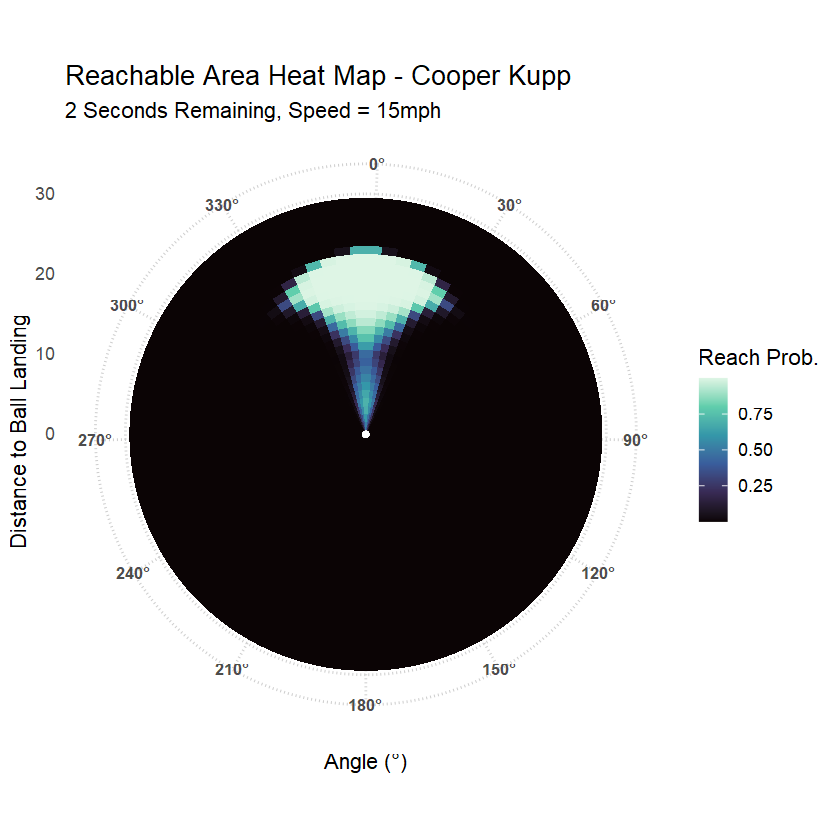

In [56]:
test_df <- expand.grid(
  nfl_id = 44881, # 54508 for wandale robinson, 44881 for cooper kupp, 53434 jamarr chase
  dist_to_ball_land = seq(1, 30),
  time_left_s = 2,
  angle_diff = seq(0, 180, 5),
  speed = 15, 
  accel = 0
)

test_pred <- h2o.predict(model, as.h2o(test_df))
test_probs <- as.vector(test_pred$p1)

test_df <- test_df %>% 
  mutate(pred = test_probs)

# Mirror your 0–180° data to make a full 0–360° field
test_df_mirrored <- test_df %>%
  mutate(angle_diff_mirror = angle_diff) %>%
  bind_rows(
    test_df %>%
      mutate(angle_diff_mirror = 360 - angle_diff)
  ) %>% 
  mutate(reach = pred > .5)

# Plot: 0° straight up, increasing clockwise
ggplot(test_df_mirrored, aes(x = angle_diff_mirror, y = dist_to_ball_land, fill = pred)) +
  geom_tile() +
  coord_polar(start = 0, direction = 1) +  # ✅ This combination puts 0° at top and increases clockwise
  scale_fill_viridis_c(option = "mako", name = "Reach Prob.") +
  scale_x_continuous(
    breaks = seq(0, 330, 30),
    labels = paste0(seq(0, 330, 30), "°")
  ) +
  scale_y_continuous(
    limits = c(0,30),
    breaks = seq(0, 30, 10),
    name = "Distance to Ball Landing"
  ) +
  labs(
    title = "Reachable Area Heat Map - Cooper Kupp",
    subtitle = paste("2 Seconds Remaining, Speed = 15mph"),
    x = "Angle (°)",
    y = "Distance"
  ) +
  #facet_wrap(~ reorder(time_left_s, -time_left_s)) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted"),
    #plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "right"
  ) +
  # Optional: show the player in the center
  annotate("point", x = 0, y = 0, size = .5, color = "white")


  |======================================================================| 100%
  |======================================================================| 100%


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(d[d > tolerance]):
"no non-missing arguments to min; returning Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(d[d > tolerance]):
"no non-missing arguments to min; returning Inf"
Warning message:
"Removed 1064 rows containing missing values or values outside the scale range
(`geom_tile()`)."


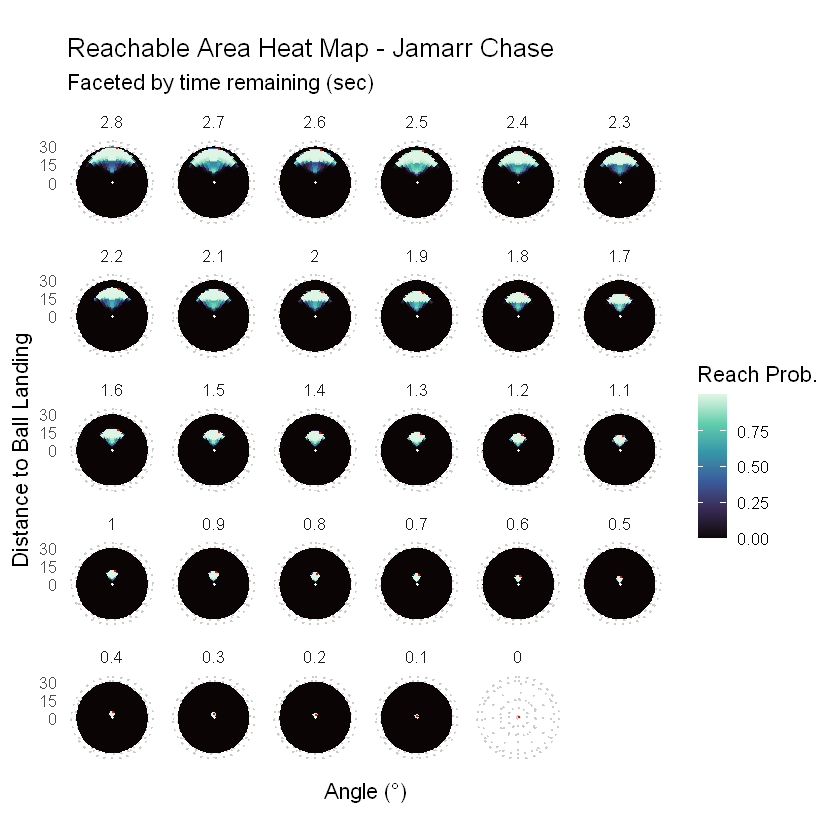

In [10]:
chase <- read.csv("chase.csv") %>%
    filter(player_role == "Targeted Receiver", !is.na(time_left_s)) %>%
    select(nfl_id, dist_to_ball_land, time_left_s, angle_diff, speed, accel)

speeds <- chase %>% 
  pull(speed)

times <- chase %>% 
  pull(time_left_s)

accels <- chase %>% 
  pull(accel)

test_df <- data.frame()
for(i in seq(1, length(times) - 1)) {
  time = times[i]
  speed = speeds[i]
  accel = accels[i]

  temp_df <- expand.grid(
    nfl_id = 53434, # 54508 for wandale robinson, 44881 for cooper kupp, 53434 jamarr chase
    dist_to_ball_land = seq(1, 30),
    time_left_s = time,
    angle_diff = seq(0, 180, 10),
    speed = speed,
    accel = accel
  )

  test_df <- bind_rows(test_df, temp_df)
}

test_pred <- h2o.predict(model, as.h2o(test_df))
test_probs <- as.vector(test_pred$p1)

test_df <- test_df %>% 
  mutate(pred = test_probs)


# Mirror your 0–180° data to make a full 0–360° field
test_df_mirrored <- test_df %>%
  mutate(angle_diff_mirror = angle_diff) %>%
  bind_rows(
    test_df %>%
      mutate(angle_diff_mirror = 360 - angle_diff)
  ) %>% 
  mutate(reach = pred > .5)

ball_df <- chase %>% 
  distinct(time_left_s, dist_to_ball_land, angle_diff)

# Plot: 0° straight up, increasing clockwise
ggplot(test_df_mirrored, aes(x = angle_diff_mirror, y = dist_to_ball_land, fill = pred)) +
  geom_tile() +
  coord_polar(start = 0, direction = 1) +  # ✅ This combination puts 0° at top and increases clockwise
  scale_fill_viridis_c(option = "mako", name = "Reach Prob.") +
  scale_x_continuous(
    breaks = seq(0, 330, 30),
    #labels = paste0(seq(0, 330, 30), "°")
    labels = NULL
  ) +
  scale_y_continuous(
    limits = c(0,30),
    breaks = seq(0, 30, 15),
    name = "Distance to Ball Landing"
  ) +
  labs(
    title = "Reachable Area Heat Map - Jamarr Chase",
    subtitle = paste("Faceted by time remaining (sec)"),
    x = "Angle (°)",
    y = "Distance"
  ) +
  facet_wrap(~ reorder(time_left_s, -time_left_s)) +
  theme_minimal(base_size = 13) +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted"),
    #plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.text.x = element_text(size = 10, face = "bold"),
    legend.position = "right"
  ) +
  # Optional: show the player in the center
  annotate("point", x = 0, y = 0, size = .5, color = "white") + 
  geom_point(
    data = ball_df,
    aes(x = angle_diff, y = dist_to_ball_land),
    color = "red",
    size = .2,
    inherit.aes = FALSE
  )


In [ ]:
extra_data <- data %>% 
  select(game_id, play_id, frame_id, x, y, 15:28)


In [ ]:
head(extra_data)

game_id,play_id,frame_id,x,y,time_left_s,dist_to_ball_land,speed,direction,accel,accel_direction,optimal_angle,angle_diff,final_frame,reached_ball,pred1,pred2,effect,display_name
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2023090700,101,1,53.20,13.98,2.0,17.40240,7.864477,-11.73857,-0.35522904,-46.33304,-54.68431,42.94574,0,0,2.694742e-03,0.134347065,-0.131652323,Josh Reynolds
2023090700,101,2,53.96,13.78,1.9,16.80744,7.858753,-14.74356,-0.05724015,-104.03624,-56.40448,41.66092,0,0,3.549731e-03,0.070086685,-0.066536954,Josh Reynolds
2023090700,101,3,54.70,13.54,1.8,16.20528,7.779460,-17.96914,-0.79292946,-116.56505,-58.11455,40.14541,0,0,7.563702e-04,0.030466502,-0.029710132,Josh Reynolds
2023090700,101,4,55.41,13.27,1.7,15.60777,7.596052,-20.82089,-1.83408530,-135.00000,-59.80434,38.98345,0,0,1.450470e-05,0.008431210,-0.008416705,Josh Reynolds
2023090700,101,5,56.09,12.95,1.6,14.99526,7.515318,-25.20112,-0.80733915,-120.96376,-61.43529,36.23416,0,0,6.486375e-06,0.004115084,-0.004108597,Josh Reynolds
2023090700,101,6,56.73,12.58,1.5,14.36944,7.392564,-30.03328,-1.22753860,-128.65981,-62.97132,32.93804,0,0,8.299145e-07,0.001325235,-0.001324405,Josh Reynolds
